In [1]:
import numpy as np                                                                                                                    
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.nn.functional import one_hot
from abc import abstractmethod, ABC 
import tqdm
import matplotlib.pyplot as plt
from functools import partial
import os
import argparse
from functools import partial


# Feed forward Neural network and utils

- Feedforward neural network
- Parameters Initilisation function
- Freezing / Unfreezing of networks' parameters

In [2]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity):
        super().__init__()

        layers = []
        layers.append(nn.BatchNorm1d(sizes[0]))
        for j in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[j-1], sizes[j]))
            if j<(len(sizes)-1):
                layers.append(nn.BatchNorm1d(sizes[j]))
                layers.append(activation())
            else:
                #layers.append(nn.BatchNorm1d(sizes[j]))
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def forward(self, *args):
        x = torch.cat(args, -1)
    
        return self.net(x)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias)#m.bias.zero_()#, gain=nn.init.calculate_gain('relu'))
        
# freeze / unfreeze networks' parameters
def toggle(net: nn.Module,  to: bool):
    for p in net.parameters():
        p.requires_grad_(to)


# Utility function

In [3]:
def U(x, a):
    """ Utility function
    Parameters
    ----------
    a: float
        Utility parameter
    x: torch.Tensor
        Tensor of shape (batch_size, 1)
    """
    assert a>0, 'a needs to be positive'
    output = torch.zeros_like(x)
    output[x.lt(0)] = x[x.lt(0)]
    output[x.ge(0)] = 1-torch.exp(-a*x[x.ge(0)])
    return output


# Utils

- Brownian bridge
- Geometric Brownian motion with zero drift
- Sampling of initial reserves and mid price $(S_0, R^\alpha_0, R^\beta_0)$

In [4]:
def Brownian_bridge_step(b: torch.Tensor, t: float, T: float, tau: float, **kwargs):
    """
    Step of Brownian bridge given by SDE
    dS_t = (b-S_t)/(T-t)dt + dW_t , S_0 = a 

    Parameters
    ----------
    t: float
        current time 
    T: float
        final time 
    tau: float
        time discretisation step size
    b: torch.Tensor
        Tensor of shape (batch_size, *). Samples of S_t at current time t
    """
    
    next_b = b + (-b)/(T-t) * tau + np.sqrt(tau) * torch.randn_like(b)
    return next_b


def GBM_step(sigma: float, tau: float, s: torch.Tensor, **kwargs):
    """
    Step of GBM with zero drift
    """
    if kwargs['increment_type'] == "Brownian Bridge":
        s_next = s * torch.exp(-0.5 * sigma**2 * tau + sigma * kwargs['dW'])
    else:
        s_next = s * torch.exp(-0.5 * sigma**2 * tau + sigma * np.sqrt(tau)*torch.randn_like(s)) 
    return s_next

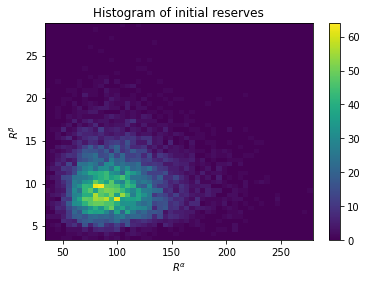

In [3]:
def sample_x0(batch_size, dim, device='cpu', ):
    """
    R^\alpha and R^beta are sampled from a Lognormal
    S = R^\alpha / R^beta plus some noise
    """
    sigma = 0.3
    mu = np.log(10)#np.log(10000.0)
    z = torch.randn(batch_size, dim, device=device)
    x0 = torch.exp((mu-0.5*sigma**2) + sigma*z) # lognormal
    x0[:,1] = x0[:,1] * 10 
    x0[:,0] = torch.clamp(x0[:,1]/x0[:,2] + 5*torch.randn_like(x0[:,0]), min=5.)
    #x0 = -10 + 20*torch.rand(batch_size, dim, device=device)
    return x0

x0 = sample_x0(10000, dim=3).numpy()
plt.hist2d(x0[:,1], x0[:,2], bins=50)
plt.colorbar()
plt.title(r'Histogram of initial reserves')
plt.xlabel(r'$R^\alpha$')
plt.ylabel(r'$R^\beta$')
plt.show()


In [20]:
def make_plots(agent, path_results, n_mc, render=False, **kwargs):
    """
    kwargs: dict
        arguments for s process
    """

    agent.v.eval()
    agent.alpha.eval()
    agent.C.eval()
    x0 = sample_x0(n_mc, 3, device=device)
    n_steps = 100
    
    if kwargs['increment_type'] == "Brownian Bridge":
        kwargs.update(dict(b=torch.zeros_like(x0[:,0]), T=kwargs['tau']*n_steps))

    x0[:,0] = x0[:,1] / x0[:,2]
    path = [x0]
    actions = []
    PnL = []
    utility = []
    
    for i in range(1, n_steps):
        kwargs['t'] = i * kwargs['tau']
        with torch.no_grad():
            a, x, u, profit_alpha = agent.step(path[-1], n_mc=1, train=False, **kwargs)
        PnL.append(profit_alpha)
        path.append(x)
        actions.append(a)
        utility.append(u.reshape(-1))
    path = torch.stack(path, 1)
    s, r_alpha, r_beta = path[...,0].cpu(), path[...,1].cpu(), path[...,2].cpu() # (n_mc, L)
    V = r_alpha + s*r_beta # (n_mc, L)
    actions = torch.stack(actions, 1) # (n_mc, L, 3)
    PnL = torch.stack(PnL,1) # (n_mc, L)
    utility = torch.stack(utility, 1) # (n_mc, L)
    c = actions[...,-3:]
    
    if render and n_mc<=10:
        for i in range(n_mc):
            print(i)
            fig, ax = plt.subplots(1,3, figsize=(12,4))
            ax[0].plot(actions[i,:,0].cpu().numpy(), '.--', label=r'$\Delta^\alpha$')
            ax[0].plot(actions[i,:,1].cpu().numpy(), '.--', label=r'$\Delta^\beta$')
            ax[0].set_title('Action')
            ax[0].set_xlabel('Step')
            ax[0].set_ylabel('Amount')
            ax[0].legend()
            ax[0].grid()
            ax[1].plot(PnL[i].cumsum(0).cpu())
            ax[1].set_title('Cumulative PnL')
            ax[1].set_xlabel('Step')
            ax[1].set_ylabel(r'Profit in $\alpha$')
            ax[1].grid()
            ax[2].plot(r_alpha[i]/r_beta[i], label=r'$R^\alpha / R^\beta$')
            ax[2].plot(s[i], label=r'$S$')
            ax[2].set_title(r'$(S_t, R_t^\alpha / R^\beta)$ evolution')
            ax[2].set_xlabel('Step')
            ax[2].set_ylabel('Amount')
            ax[2].legend()
            ax[2].grid()
            fig.tight_layout()
            fig.savefig(os.path.join(path_results, 'trajectories_{}.pdf'.format(i)))
            plt.show()
            #plt.close()
    
    return (V[:,-1]-V[:,0]).numpy() # n_mc

# Actor Critic class

In [21]:
class ActorCritic():
    
    def __init__(self, a: float, gamma: float, kappa: float, discount_factor: float, device = 'cpu', **kwargs):

        """
        
        Parameters
        ----------
        discount_factor: float
            Discount factor in Bellman equation between (0,1)
        tau: float
            Change of time, in time discretisation
        sigma: float
            Diffusion in LQR SDE. I assume the diffusion is constant. Can be easily changed
        gamma: float
            (1-gmma) is fee
        kappa: float
            slippage        
        device: str
            Device where things are run
        
        
        """
        self.d = 3 # dimension of the state (s, r_alpha, r_beta)
        self.device=device
                
        # Running cost 
        self.f = partial(U, a=a)
        
        # fee
        self.gamma = gamma
        
        # slippage
        self.kappa = kappa
        
        # policy
        self.alpha = FFN(sizes = [self.d + 1] + kwargs['hidden_dims'] + [2], output_activation=nn.Softplus).to(device) # Soft policy. input of alpha is (s,r^alpha, r^beta,z) where z is input noise
        self.C = FFN(sizes = [self.d] + kwargs['hidden_dims'] + [3], output_activation=nn.Softmax).to(device) # if C=0 sell alpha. if C=1 sell beta
        self.alpha.apply(init_weights)
        self.optimizer_alpha = torch.optim.Adam(list(self.alpha.parameters()) + list(self.C.parameters()), lr=0.005)
        self.scheduler_alpha = torch.optim.lr_scheduler.MultiStepLR(self.optimizer_alpha, milestones=[1000], gamma=0.1)
        
        # value function
        self.v = FFN(sizes = [self.d] + kwargs['hidden_dims'] + [1]).to(device) # input of v is x
        self.v.apply(init_weights)
        self.optimizer_v = torch.optim.Adam(self.v.parameters(), lr=0.005)
        self.scheduler_v = torch.optim.lr_scheduler.MultiStepLR(self.optimizer_v, milestones=[1000], gamma=0.1)
        
        # discount factor for Bellman equation
        self.discount_factor = discount_factor
        
        
    
    def step(self, x: torch.Tensor, n_mc: int, train: bool = True, **kwargs):
        """

        Parameters
        ----------
        x: torch.Tensor
            State
        n_mc: int
            Monte Carlo samples to approximate explorative running_cost
        train: bool
            boolean that tells whether we are training, or whether we are sampling from the soft policy
        kwargs: dict
            arguments necessary to calculate a step of mid-price 
        """
        n_batch = x.shape[0]
        # MONTE CARLO!
        x_mc = torch.repeat_interleave(x, n_mc, dim=0) # (n_mc * n_batch, d)
        z_a = 2*torch.randn(n_mc*n_batch, 1, device=x.device) # input noise for the policy generator
        a = self.alpha(x_mc, z_a)
        c = self.C(x_mc)#.reshape(-1)
        
        # Environment step
        s, r_alpha, r_beta = x_mc[:,0], x_mc[:,1], x_mc[:,2] 
        Delta_alpha, Delta_beta = a[:,0], a[:,1]
        
        if not train:
            m = Categorical(c)
            c = one_hot(m.sample(), num_classes = 3)
            Delta_alpha[c[:,1].eq(0.)] = 0
            Delta_beta[c[:,0].eq(0.)] = 0
        
        #z_s = torch.randn_like(s) # (n_mc*n_batch, device=x.device)
        if kwargs.get('increment_type') == 'Brownian Bridge':
            b_next = Brownian_bridge_step(**kwargs)
            kwargs['dW'] = b_next.clone() - kwargs['b'].clone()
            kwargs['b'] = b_next.clone()

        s_step = partial(GBM_step, **kwargs)
        s_next = s_step(s=s) #s * torch.exp(-0.5 * self.sigma**2 * self.tau + self.sigma * np.sqrt(self.tau)*z_s) # (n_mc*n_batch)
        
        r_alpha_next = c[:,0] * r_alpha*r_beta / (r_beta + self.gamma*Delta_beta) + c[:,1] * (r_alpha + Delta_alpha) + c[:,2] * r_alpha
        r_beta_next = c[:,0] * (r_beta + Delta_beta) + c[:,1] * r_alpha*r_beta / (r_alpha + self.gamma*Delta_alpha) + c[:,2] * r_beta

        profit_alpha = c[:,0] * (r_alpha - r_alpha*r_beta / (r_beta + self.gamma*Delta_beta) - Delta_beta*(s-self.kappa*Delta_beta))
        Delta_beta_const_market = r_beta - r_alpha*r_beta/(r_alpha + self.gamma*Delta_alpha)
        profit_alpha += c[:,1] * (Delta_beta_const_market * (s - self.kappa*Delta_beta_const_market) - Delta_alpha)
        running_cost = self.f(profit_alpha).reshape(-1,1)
       
        x_next = torch.stack((s_next, r_alpha_next, r_beta_next), dim=1)
        
        return torch.cat([a, c],1), x_next, running_cost, profit_alpha

    
    
    
    def _dynamic_programming(self, x: torch.Tensor, n_mc: int, **kwargs):
        """
        Performs one step environment step and return bellman loss
        
        Parameters
        ----------
        x: torch.Tensor
            tensor. tensor of shape (N_batch, 3)
        n_mc: int
            Number of monte carlo samples to approximate drift
        kwargs: dict
            arguments necessary to calculate a step of mid-price 
        
        Returns
        ------
        bellman_loss: torch.Tensor
            bellman loss: ( v(x) - 1/N_mc \sum(f + delta * v(x_next)) )^2
        
        bellman_approx: torch.Tensor
            bellman approximation of v(x): 1/N_mc \sum(f + delta * v(x_next))
        
        """
        n_batch = x.shape[0]
        _, x_next, running_cost, _ = self.step(x, n_mc, train=True, **kwargs)
        
        # bellman approx
        bellman_approx = running_cost + self.discount_factor * self.v(x_next) # (n_batch*n_mc, 1)
        bellman_approx = bellman_approx.reshape(n_batch, n_mc, -1).mean(1) # (n_batch, 1)
        
        # bellman loss
        bellman_loss = torch.pow(self.v(x) - bellman_approx.detach(),2).mean()
        return bellman_loss, bellman_approx.mean()
    
    def update_alpha(self, n_batch, n_mc, **kwargs):
        """
        Gradient ascent on alpha to maximise bellman approx

        Parameters
        ----------
        n_batch: int
            batch size
        n_mc: int
            Monte Carlo size for Monte Carlo approximation of running cost to have some exploration
        kwargs: dict
            arguments necessary to calculate a step of mid-price 
        """
        
        toggle(self.v, to=False)
        toggle(self.alpha, to=True)
        toggle(self.C, to=True)
        #self.v.eval()
        self.alpha.train()
        self.C.train()
        
        #x0 = torch.randn(n_batch, self.d)
        x0 = sample_x0(n_batch, self.d, device = self.device)
        self.optimizer_alpha.zero_grad()
        _, bellman_approx = self._dynamic_programming(x0, n_mc, **kwargs)
        bellman_approx = -1 * bellman_approx # we want to maximise!
        bellman_approx.backward()
        self.optimizer_alpha.step()
        self.scheduler_alpha.step()
        return -bellman_approx.detach()
    
    def update_v(self, n_batch, n_mc, **kwargs):
        """
        Gradient descent on to minimise bellman loss
        
        Parameters
        ----------
        n_batch: int
            batch size
        n_mc: int
            Monte Carlo size for Monte Carlo approximation of running cost to have some exploration
        kwargs: dict
            arguments necessary to calculate a step of mid-price 
        """
        
        toggle(self.v, to=True)
        toggle(self.alpha, to=False)
        toggle(self.C, to=False)
        self.v.train()
        
        x0 = sample_x0(n_batch, self.d, device=self.device)
        self.optimizer_v.zero_grad()
        bellman_loss, _ = self._dynamic_programming(x0, n_mc, **kwargs)
        bellman_loss.backward()
        self.optimizer_v.step()
        self.scheduler_v.step()
        return bellman_loss.detach()

# Learning

Disclaimer: I take different values than in the paper and different reserves initialisation, so that it trains faster, as this notebook is being trained on a cpu. 

In [25]:
torch.manual_seed(0)
np.random.seed(0)

results_path = './numerical_results'
if not os.path.exists(results_path):
    os.makedirs(results_path)


a = 0.1 # utility function parameter
gamma = 0.99 # (1-gamma) being fee
kappa = 0.001 # slippage
sigma = 0.3 # diffusion of GBM                                                                                                            
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

discount_factor = 0.8
tau = 0.1 # time discretisation step length

# learning hyperparameters
n_batch = 200
n_mc = 200
hidden_dims = [20,20]
n_updates_alpha = 10
n_updates_v = 10
max_updates = 2000#10000

agent = ActorCritic(a=a, gamma=gamma, kappa=kappa, discount_factor=discount_factor, hidden_dims=hidden_dims, device=device)




Try to load a pre-trained agent

In [26]:
# learning
continue_training = False 

results_path = './numerical_results'
if not os.path.exists(results_path):
    os.makedirs(results_path)

if continue_training:
    try:
        state = torch.load(os.path.join(results_path, 'state.pth.tar'), map_location=device)
        loading_success = True
        print('success')
    except:
        print("I could not load a pre-trained model")
        loading_success = False
    if loading_success:
        agent.alpha.load_state_dict(state['alpha'])
        agent.v.load_state_dict(state['v'])
        agent.C.load_state_dict(state['C'])


In [27]:
s_args = dict(sigma=sigma, tau=tau, increment_type="BM")
# learning
pbar = tqdm.tqdm(total = max_updates)
count = 0
bellman_loss = []
bellman_approx = []
while count < max_updates:

    for i in range(n_updates_v):
        loss = agent.update_v(n_batch = n_batch, n_mc = n_mc, **s_args)
        bellman_loss.append(loss)
    pbar.write('bellman loss: {:1.2e}'.format(loss.item()))

    for i in range(n_updates_alpha):
        v_approx = agent.update_alpha(n_batch = n_batch, n_mc = n_mc, **s_args)
        bellman_approx.append(v_approx)
    pbar.write('bellman approx: {:1.2e}'.format(v_approx.item()))

    count += n_updates_alpha + n_updates_v
    pbar.update(n_updates_alpha + n_updates_v)

# save results
state = {"alpha":agent.alpha.state_dict(), "v":agent.v.state_dict(), "C": agent.C.state_dict()}
torch.save(state, os.path.join(results_path, "state.pth.tar"))


  0%|                                                                                                                                                                                                                                                 | 0/2000 [00:00<?, ?it/s]

bellman loss: 5.71e+01


  1%|██▎                                                                                                                                                                                                                                     | 20/2000 [00:03<05:43,  5.77it/s]

bellman approx: -7.42e-01


  1%|██▎                                                                                                                                                                                                                                     | 20/2000 [00:04<05:43,  5.77it/s]

bellman loss: 3.04e-01


  2%|████▋                                                                                                                                                                                                                                   | 40/2000 [00:06<05:42,  5.72it/s]

bellman approx: -9.26e-01


  2%|████▋                                                                                                                                                                                                                                   | 40/2000 [00:07<05:42,  5.72it/s]

bellman loss: 3.43e-01


  3%|██████▉                                                                                                                                                                                                                                 | 60/2000 [00:10<05:41,  5.69it/s]

bellman approx: -8.78e-01


  3%|██████▉                                                                                                                                                                                                                                 | 60/2000 [00:11<05:41,  5.69it/s]

bellman loss: 2.75e-01


  4%|█████████▎                                                                                                                                                                                                                              | 80/2000 [00:14<05:37,  5.69it/s]

bellman approx: -8.65e-01


  4%|█████████▎                                                                                                                                                                                                                              | 80/2000 [00:15<05:37,  5.69it/s]

bellman loss: 2.49e-01


  5%|███████████▌                                                                                                                                                                                                                           | 100/2000 [00:17<05:33,  5.70it/s]

bellman approx: -6.80e-01


  5%|███████████▌                                                                                                                                                                                                                           | 100/2000 [00:18<05:33,  5.70it/s]

bellman loss: 2.26e-01


  6%|█████████████▊                                                                                                                                                                                                                         | 120/2000 [00:21<05:30,  5.70it/s]

bellman approx: -5.50e-01


  6%|█████████████▊                                                                                                                                                                                                                         | 120/2000 [00:21<05:30,  5.70it/s]

bellman loss: 1.60e-01


  7%|████████████████▏                                                                                                                                                                                                                      | 140/2000 [00:24<05:23,  5.75it/s]

bellman approx: -3.86e-01


  7%|████████████████▏                                                                                                                                                                                                                      | 140/2000 [00:25<05:23,  5.75it/s]

bellman loss: 1.35e-01


  8%|██████████████████▍                                                                                                                                                                                                                    | 160/2000 [00:28<05:21,  5.72it/s]

bellman approx: -2.24e-01


  8%|██████████████████▍                                                                                                                                                                                                                    | 160/2000 [00:29<05:21,  5.72it/s]

bellman loss: 1.22e-01


  9%|████████████████████▊                                                                                                                                                                                                                  | 180/2000 [00:32<05:38,  5.37it/s]

bellman approx: -2.87e-02


  9%|████████████████████▊                                                                                                                                                                                                                  | 180/2000 [00:33<05:38,  5.37it/s]

bellman loss: 8.65e-02


 10%|███████████████████████                                                                                                                                                                                                                | 200/2000 [00:36<05:42,  5.25it/s]

bellman approx: 1.27e-01


 10%|███████████████████████                                                                                                                                                                                                                | 200/2000 [00:37<05:42,  5.25it/s]

bellman loss: 1.01e-01


 11%|█████████████████████████▍                                                                                                                                                                                                             | 220/2000 [00:39<05:37,  5.28it/s]

bellman approx: 2.60e-01


 11%|█████████████████████████▍                                                                                                                                                                                                             | 220/2000 [00:40<05:37,  5.28it/s]

bellman loss: 1.00e-01


 12%|███████████████████████████▋                                                                                                                                                                                                           | 240/2000 [00:43<05:31,  5.31it/s]

bellman approx: 3.84e-01


 12%|███████████████████████████▋                                                                                                                                                                                                           | 240/2000 [00:44<05:31,  5.31it/s]

bellman loss: 9.57e-02


 13%|██████████████████████████████                                                                                                                                                                                                         | 260/2000 [00:47<05:27,  5.31it/s]

bellman approx: 4.30e-01


 13%|██████████████████████████████                                                                                                                                                                                                         | 260/2000 [00:48<05:27,  5.31it/s]

bellman loss: 6.79e-02


 14%|████████████████████████████████▎                                                                                                                                                                                                      | 280/2000 [00:51<05:19,  5.38it/s]

bellman approx: 4.96e-01


 14%|████████████████████████████████▎                                                                                                                                                                                                      | 280/2000 [00:52<05:19,  5.38it/s]

bellman loss: 6.95e-02


 15%|██████████████████████████████████▋                                                                                                                                                                                                    | 300/2000 [00:54<05:13,  5.42it/s]

bellman approx: 5.54e-01


 15%|██████████████████████████████████▋                                                                                                                                                                                                    | 300/2000 [00:55<05:13,  5.42it/s]

bellman loss: 5.75e-02


 16%|████████████████████████████████████▉                                                                                                                                                                                                  | 320/2000 [00:58<05:08,  5.45it/s]

bellman approx: 5.87e-01


 16%|████████████████████████████████████▉                                                                                                                                                                                                  | 320/2000 [00:59<05:08,  5.45it/s]

bellman loss: 6.94e-02


 17%|███████████████████████████████████████▎                                                                                                                                                                                               | 340/2000 [01:02<05:08,  5.37it/s]

bellman approx: 6.85e-01


 17%|███████████████████████████████████████▎                                                                                                                                                                                               | 340/2000 [01:03<05:08,  5.37it/s]

bellman loss: 5.48e-02


 18%|█████████████████████████████████████████▌                                                                                                                                                                                             | 360/2000 [01:05<05:02,  5.41it/s]

bellman approx: 6.56e-01


 18%|█████████████████████████████████████████▌                                                                                                                                                                                             | 360/2000 [01:06<05:02,  5.41it/s]

bellman loss: 5.14e-02


 19%|███████████████████████████████████████████▉                                                                                                                                                                                           | 380/2000 [01:09<05:05,  5.30it/s]

bellman approx: 6.86e-01


 19%|███████████████████████████████████████████▉                                                                                                                                                                                           | 380/2000 [01:10<05:05,  5.30it/s]

bellman loss: 3.82e-02


 20%|██████████████████████████████████████████████▏                                                                                                                                                                                        | 400/2000 [01:13<04:58,  5.35it/s]

bellman approx: 7.03e-01


 20%|██████████████████████████████████████████████▏                                                                                                                                                                                        | 400/2000 [01:14<04:58,  5.35it/s]

bellman loss: 2.64e-02


 21%|████████████████████████████████████████████████▌                                                                                                                                                                                      | 420/2000 [01:17<04:57,  5.32it/s]

bellman approx: 7.60e-01


 21%|████████████████████████████████████████████████▌                                                                                                                                                                                      | 420/2000 [01:18<04:57,  5.32it/s]

bellman loss: 3.96e-02


 22%|██████████████████████████████████████████████████▊                                                                                                                                                                                    | 440/2000 [01:20<04:50,  5.38it/s]

bellman approx: 7.44e-01


 22%|██████████████████████████████████████████████████▊                                                                                                                                                                                    | 440/2000 [01:21<04:50,  5.38it/s]

bellman loss: 3.14e-02


 23%|█████████████████████████████████████████████████████▏                                                                                                                                                                                 | 460/2000 [01:24<04:40,  5.49it/s]

bellman approx: 8.06e-01


 23%|█████████████████████████████████████████████████████▏                                                                                                                                                                                 | 460/2000 [01:25<04:40,  5.49it/s]

bellman loss: 4.08e-02


 24%|███████████████████████████████████████████████████████▍                                                                                                                                                                               | 480/2000 [01:27<04:33,  5.56it/s]

bellman approx: 8.12e-01


 24%|███████████████████████████████████████████████████████▍                                                                                                                                                                               | 480/2000 [01:28<04:33,  5.56it/s]

bellman loss: 3.00e-02


 25%|█████████████████████████████████████████████████████████▊                                                                                                                                                                             | 500/2000 [01:31<04:34,  5.47it/s]

bellman approx: 8.47e-01


 25%|█████████████████████████████████████████████████████████▊                                                                                                                                                                             | 500/2000 [01:32<04:34,  5.47it/s]

bellman loss: 3.87e-02


 26%|████████████████████████████████████████████████████████████                                                                                                                                                                           | 520/2000 [01:35<04:42,  5.24it/s]

bellman approx: 8.95e-01


 26%|████████████████████████████████████████████████████████████                                                                                                                                                                           | 520/2000 [01:36<04:42,  5.24it/s]

bellman loss: 3.06e-02


 27%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 540/2000 [01:39<04:37,  5.26it/s]

bellman approx: 8.72e-01


 27%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 540/2000 [01:40<04:37,  5.26it/s]

bellman loss: 2.43e-02


 28%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 560/2000 [01:43<04:28,  5.36it/s]

bellman approx: 9.20e-01


 28%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 560/2000 [01:44<04:28,  5.36it/s]

bellman loss: 2.54e-02


 29%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 580/2000 [01:46<04:23,  5.39it/s]

bellman approx: 9.27e-01


 29%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 580/2000 [01:47<04:23,  5.39it/s]

bellman loss: 3.74e-02


 30%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 600/2000 [01:50<04:18,  5.41it/s]

bellman approx: 9.24e-01


 30%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 600/2000 [01:51<04:18,  5.41it/s]

bellman loss: 6.14e-02


 31%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 620/2000 [01:54<04:15,  5.39it/s]

bellman approx: 9.47e-01


 31%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 620/2000 [01:55<04:15,  5.39it/s]

bellman loss: 3.33e-02


 32%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 640/2000 [01:57<04:14,  5.35it/s]

bellman approx: 9.06e-01


 32%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 640/2000 [01:59<04:14,  5.35it/s]

bellman loss: 3.22e-02


 33%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 660/2000 [02:01<04:11,  5.32it/s]

bellman approx: 9.73e-01


 33%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 660/2000 [02:02<04:11,  5.32it/s]

bellman loss: 2.36e-02


 34%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 680/2000 [02:05<04:06,  5.35it/s]

bellman approx: 9.27e-01


 34%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 680/2000 [02:06<04:06,  5.35it/s]

bellman loss: 2.96e-02


 35%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 700/2000 [02:09<04:01,  5.38it/s]

bellman approx: 9.35e-01


 35%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 700/2000 [02:10<04:01,  5.38it/s]

bellman loss: 2.97e-02


 36%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 720/2000 [02:12<04:00,  5.33it/s]

bellman approx: 1.01e+00


 36%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 720/2000 [02:14<04:00,  5.33it/s]

bellman loss: 3.48e-02


 37%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 740/2000 [02:17<04:16,  4.91it/s]

bellman approx: 9.96e-01


 37%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 740/2000 [02:18<04:16,  4.91it/s]

bellman loss: 4.24e-02


 38%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 760/2000 [02:21<04:09,  4.96it/s]

bellman approx: 9.98e-01


 38%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 760/2000 [02:22<04:09,  4.96it/s]

bellman loss: 2.27e-02


 39%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 780/2000 [02:25<03:56,  5.17it/s]

bellman approx: 9.80e-01


 39%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 780/2000 [02:26<03:56,  5.17it/s]

bellman loss: 2.46e-02


 40%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 800/2000 [02:28<03:45,  5.31it/s]

bellman approx: 1.01e+00


 40%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 800/2000 [02:29<03:45,  5.31it/s]

bellman loss: 3.67e-02


 41%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 820/2000 [02:32<03:37,  5.42it/s]

bellman approx: 9.84e-01


 41%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 820/2000 [02:33<03:37,  5.42it/s]

bellman loss: 2.75e-02


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 840/2000 [02:35<03:30,  5.52it/s]

bellman approx: 1.05e+00


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 840/2000 [02:36<03:30,  5.52it/s]

bellman loss: 2.39e-02


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 860/2000 [02:39<03:25,  5.54it/s]

bellman approx: 1.01e+00


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 860/2000 [02:40<03:25,  5.54it/s]

bellman loss: 2.48e-02


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 880/2000 [02:43<03:24,  5.49it/s]

bellman approx: 9.93e-01


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 880/2000 [02:44<03:24,  5.49it/s]

bellman loss: 2.13e-02


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 900/2000 [02:46<03:21,  5.45it/s]

bellman approx: 9.48e-01


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 900/2000 [02:47<03:21,  5.45it/s]

bellman loss: 2.98e-02


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 920/2000 [02:50<03:20,  5.38it/s]

bellman approx: 1.01e+00


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 920/2000 [02:51<03:20,  5.38it/s]

bellman loss: 2.45e-02


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 940/2000 [02:54<03:12,  5.50it/s]

bellman approx: 1.03e+00


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 940/2000 [02:54<03:12,  5.50it/s]

bellman loss: 1.64e-02


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 960/2000 [02:57<03:05,  5.59it/s]

bellman approx: 1.00e+00


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 960/2000 [02:58<03:05,  5.59it/s]

bellman loss: 1.98e-02


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 980/2000 [03:00<03:00,  5.65it/s]

bellman approx: 1.06e+00


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 980/2000 [03:01<03:00,  5.65it/s]

bellman loss: 1.87e-02


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 1000/2000 [03:04<02:54,  5.72it/s]

bellman approx: 1.02e+00


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 1000/2000 [03:05<02:54,  5.72it/s]

bellman loss: 1.70e-02


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 1020/2000 [03:07<02:50,  5.75it/s]

bellman approx: 1.01e+00


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 1020/2000 [03:08<02:50,  5.75it/s]

bellman loss: 2.14e-02


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1040/2000 [03:11<02:45,  5.80it/s]

bellman approx: 9.58e-01


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1040/2000 [03:12<02:45,  5.80it/s]

bellman loss: 1.73e-02


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 1060/2000 [03:14<02:41,  5.83it/s]

bellman approx: 9.75e-01


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 1060/2000 [03:15<02:41,  5.83it/s]

bellman loss: 1.55e-02


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1080/2000 [03:17<02:37,  5.83it/s]

bellman approx: 9.73e-01


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1080/2000 [03:18<02:37,  5.83it/s]

bellman loss: 1.35e-02


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1100/2000 [03:21<02:41,  5.56it/s]

bellman approx: 9.63e-01


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1100/2000 [03:23<02:41,  5.56it/s]

bellman loss: 1.64e-02


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1120/2000 [03:25<02:43,  5.38it/s]

bellman approx: 1.02e+00


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1120/2000 [03:26<02:43,  5.38it/s]

bellman loss: 1.67e-02


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1140/2000 [03:29<02:40,  5.35it/s]

bellman approx: 9.77e-01


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1140/2000 [03:30<02:40,  5.35it/s]

bellman loss: 1.63e-02


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1160/2000 [03:33<02:35,  5.40it/s]

bellman approx: 1.01e+00


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1160/2000 [03:34<02:35,  5.40it/s]

bellman loss: 4.81e-02


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1180/2000 [03:37<02:36,  5.25it/s]

bellman approx: 1.02e+00


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1180/2000 [03:38<02:36,  5.25it/s]

bellman loss: 1.47e-02


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1200/2000 [03:41<02:36,  5.12it/s]

bellman approx: 9.77e-01


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1200/2000 [03:42<02:36,  5.12it/s]

bellman loss: 1.52e-02


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1220/2000 [03:45<02:29,  5.21it/s]

bellman approx: 1.02e+00


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1220/2000 [03:46<02:29,  5.21it/s]

bellman loss: 1.30e-02


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1240/2000 [03:48<02:24,  5.27it/s]

bellman approx: 1.02e+00


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1240/2000 [03:49<02:24,  5.27it/s]

bellman loss: 1.47e-02


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1260/2000 [03:52<02:16,  5.41it/s]

bellman approx: 9.90e-01


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1260/2000 [03:53<02:16,  5.41it/s]

bellman loss: 2.92e-02


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1280/2000 [03:56<02:13,  5.39it/s]

bellman approx: 1.02e+00


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1280/2000 [03:57<02:13,  5.39it/s]

bellman loss: 5.01e-02


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1300/2000 [03:59<02:09,  5.42it/s]

bellman approx: 9.73e-01


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1300/2000 [04:00<02:09,  5.42it/s]

bellman loss: 1.40e-02


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1320/2000 [04:03<02:02,  5.53it/s]

bellman approx: 1.01e+00


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1320/2000 [04:04<02:02,  5.53it/s]

bellman loss: 2.01e-02


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1340/2000 [04:07<02:01,  5.43it/s]

bellman approx: 1.08e+00


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1340/2000 [04:08<02:01,  5.43it/s]

bellman loss: 2.27e-02


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1360/2000 [04:11<02:03,  5.16it/s]

bellman approx: 1.02e+00


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1360/2000 [04:12<02:03,  5.16it/s]

bellman loss: 1.55e-02


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1380/2000 [04:15<02:02,  5.06it/s]

bellman approx: 1.10e+00


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1380/2000 [04:16<02:02,  5.06it/s]

bellman loss: 1.47e-02


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1400/2000 [04:19<01:56,  5.14it/s]

bellman approx: 1.02e+00


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1400/2000 [04:20<01:56,  5.14it/s]

bellman loss: 1.35e-02


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1420/2000 [04:22<01:48,  5.33it/s]

bellman approx: 9.85e-01


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1420/2000 [04:23<01:48,  5.33it/s]

bellman loss: 1.39e-02


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1440/2000 [04:26<01:42,  5.46it/s]

bellman approx: 9.95e-01


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1440/2000 [04:27<01:42,  5.46it/s]

bellman loss: 1.18e-02


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1460/2000 [04:29<01:37,  5.54it/s]

bellman approx: 1.06e+00


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1460/2000 [04:30<01:37,  5.54it/s]

bellman loss: 1.11e-02


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1480/2000 [04:33<01:32,  5.63it/s]

bellman approx: 1.05e+00


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1480/2000 [04:33<01:32,  5.63it/s]

bellman loss: 1.36e-02


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1500/2000 [04:36<01:28,  5.68it/s]

bellman approx: 1.09e+00


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1500/2000 [04:37<01:28,  5.68it/s]

bellman loss: 1.16e-02


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1520/2000 [04:39<01:23,  5.72it/s]

bellman approx: 1.11e+00


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1520/2000 [04:40<01:23,  5.72it/s]

bellman loss: 2.85e-02


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1540/2000 [04:43<01:19,  5.78it/s]

bellman approx: 1.03e+00


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1540/2000 [04:44<01:19,  5.78it/s]

bellman loss: 3.19e-02


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1560/2000 [04:46<01:17,  5.66it/s]

bellman approx: 1.07e+00


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1560/2000 [04:47<01:17,  5.66it/s]

bellman loss: 1.81e-02


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1580/2000 [04:50<01:15,  5.58it/s]

bellman approx: 1.02e+00


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1580/2000 [04:51<01:15,  5.58it/s]

bellman loss: 1.41e-02


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1600/2000 [04:54<01:10,  5.67it/s]

bellman approx: 1.03e+00


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1600/2000 [04:54<01:10,  5.67it/s]

bellman loss: 1.28e-02


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1620/2000 [04:57<01:06,  5.74it/s]

bellman approx: 1.04e+00


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1620/2000 [04:58<01:06,  5.74it/s]

bellman loss: 1.08e-02


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1640/2000 [05:00<01:02,  5.76it/s]

bellman approx: 1.01e+00


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1640/2000 [05:01<01:02,  5.76it/s]

bellman loss: 1.51e-02


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1660/2000 [05:04<00:58,  5.81it/s]

bellman approx: 1.05e+00


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1660/2000 [05:05<00:58,  5.81it/s]

bellman loss: 1.34e-02


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1680/2000 [05:07<00:54,  5.86it/s]

bellman approx: 1.03e+00


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1680/2000 [05:08<00:54,  5.86it/s]

bellman loss: 1.12e-02


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1700/2000 [05:11<00:51,  5.85it/s]

bellman approx: 1.05e+00


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1700/2000 [05:11<00:51,  5.85it/s]

bellman loss: 1.45e-02


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1720/2000 [05:14<00:47,  5.86it/s]

bellman approx: 9.93e-01


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1720/2000 [05:15<00:47,  5.86it/s]

bellman loss: 1.84e-02


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1740/2000 [05:17<00:44,  5.84it/s]

bellman approx: 1.01e+00


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1740/2000 [05:18<00:44,  5.84it/s]

bellman loss: 1.47e-02


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1760/2000 [05:21<00:41,  5.83it/s]

bellman approx: 1.04e+00


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1760/2000 [05:22<00:41,  5.83it/s]

bellman loss: 1.28e-02


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1780/2000 [05:24<00:38,  5.75it/s]

bellman approx: 1.02e+00


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1780/2000 [05:25<00:38,  5.75it/s]

bellman loss: 1.46e-02


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1800/2000 [05:28<00:34,  5.78it/s]

bellman approx: 1.02e+00


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1800/2000 [05:29<00:34,  5.78it/s]

bellman loss: 1.21e-02


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1820/2000 [05:32<00:32,  5.59it/s]

bellman approx: 1.06e+00


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1820/2000 [05:33<00:32,  5.59it/s]

bellman loss: 8.22e-03


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1840/2000 [05:36<00:29,  5.44it/s]

bellman approx: 1.02e+00


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1840/2000 [05:37<00:29,  5.44it/s]

bellman loss: 1.12e-02


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1860/2000 [05:40<00:26,  5.34it/s]

bellman approx: 1.03e+00


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1860/2000 [05:41<00:26,  5.34it/s]

bellman loss: 1.04e-02


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1880/2000 [05:43<00:22,  5.30it/s]

bellman approx: 1.10e+00


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1880/2000 [05:44<00:22,  5.30it/s]

bellman loss: 1.47e-02


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1900/2000 [05:47<00:18,  5.41it/s]

bellman approx: 1.05e+00


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1900/2000 [05:48<00:18,  5.41it/s]

bellman loss: 2.02e-02


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1920/2000 [05:51<00:14,  5.40it/s]

bellman approx: 1.04e+00


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1920/2000 [05:52<00:14,  5.40it/s]

bellman loss: 1.16e-02


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1940/2000 [05:54<00:10,  5.48it/s]

bellman approx: 1.04e+00


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1940/2000 [05:55<00:10,  5.48it/s]

bellman loss: 8.66e-03


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1960/2000 [05:58<00:07,  5.51it/s]

bellman approx: 1.03e+00


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1960/2000 [05:59<00:07,  5.51it/s]

bellman loss: 1.33e-02


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1980/2000 [06:01<00:03,  5.55it/s]

bellman approx: 1.03e+00


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1980/2000 [06:02<00:03,  5.55it/s]

bellman loss: 1.13e-02


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:05<00:00,  5.64it/s]

bellman approx: 1.01e+00


# Plots

Text(0, 0.5, 'Bellman loss')

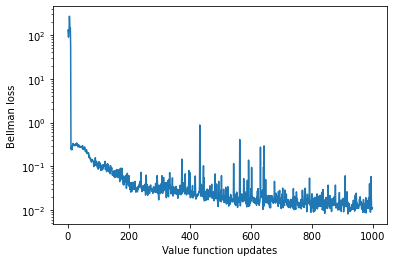

In [28]:
plt.plot(bellman_loss)
plt.yscale('log')
plt.xlabel('Value function updates')
plt.ylabel('Bellman loss')

Text(0, 0.5, 'Bellman approximation of value function')

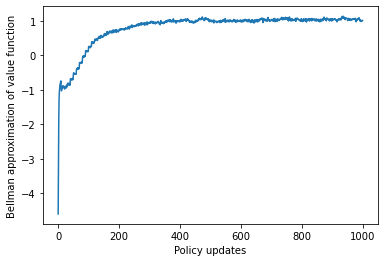

In [29]:
plt.plot(bellman_approx)
plt.xlabel('Policy updates')
plt.ylabel('Bellman approximation of value function')

0


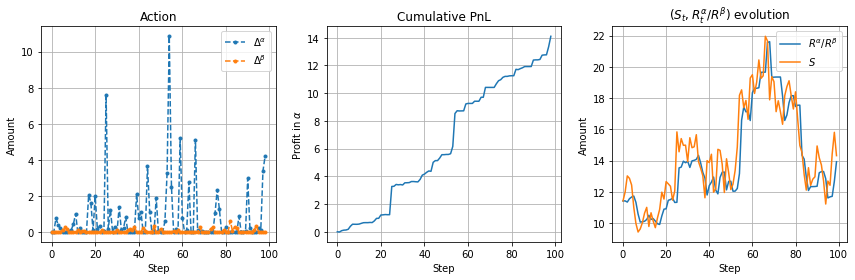

1


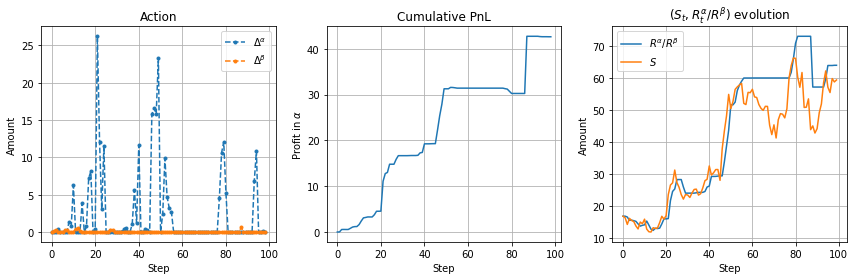

2


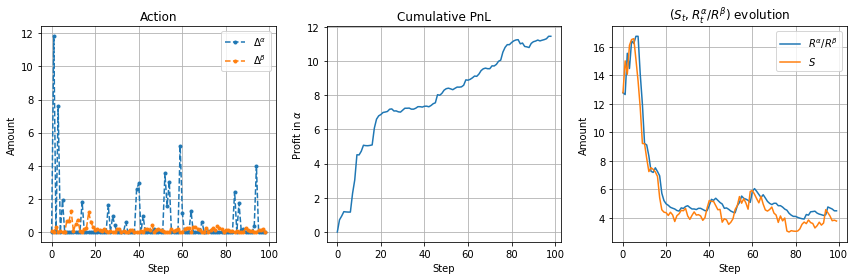

3


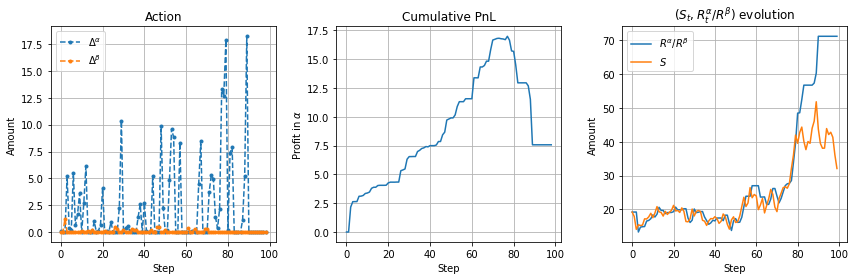

4


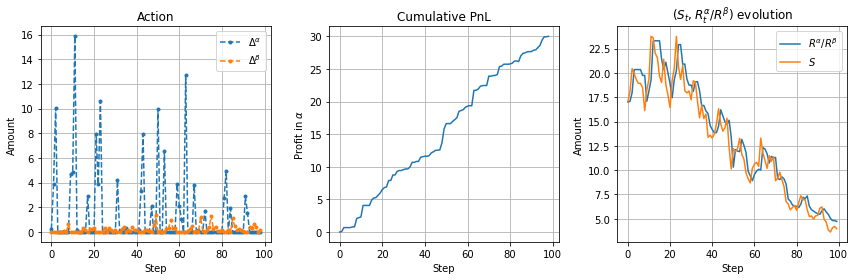

5


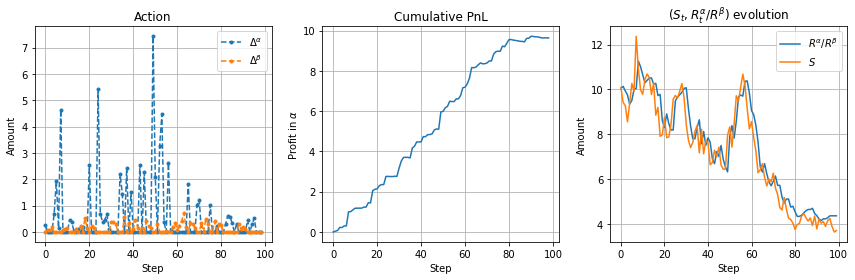

6


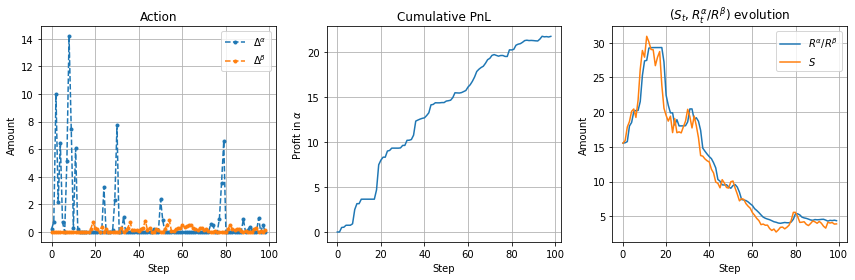

7


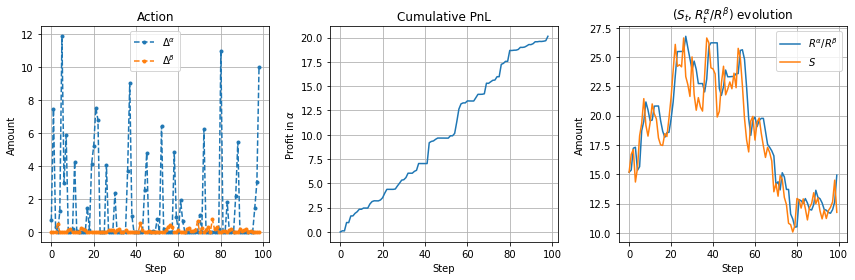

8


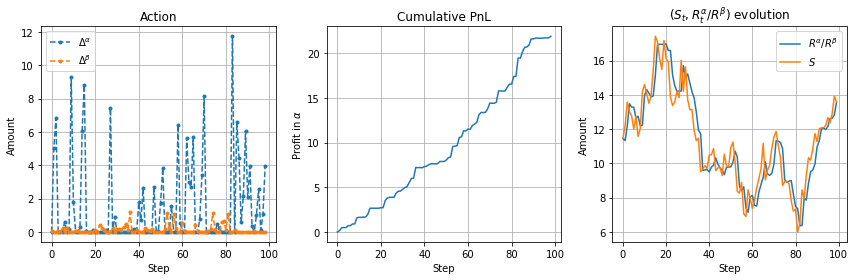

9


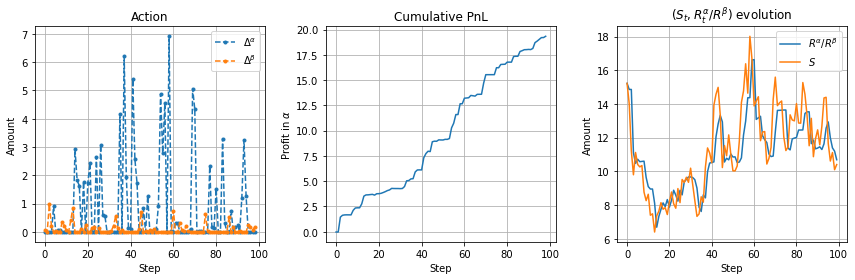

array([  21.157288,  295.02963 ,  -97.85546 ,   96.74469 , -153.56952 ,
        -60.286964, -141.31409 ,  -25.981613,   26.352081,  -30.494324],
      dtype=float32)

In [30]:
mc = 10
s_args = dict(sigma=sigma, tau=tau, increment_type="Brownian Bridge")
make_plots(agent, results_path, mc, render=True, **s_args)